[From official `scikit-learn` documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html)<br>

# Classification with Decision Tree - hyperparameter tuning (__model selection__) with Grid Search and Cross Validation

We use here the Decision Tree and the standard `CrossValidation`, then find the best hyperparameter setting through _grid search_


### Workflow
1. download the data
1. data exploration
1. drop the useless data (if any)
1. separe the predicting attributes X from the class attribute y
1. split X and y into training and test
    - set a variable `target` with the column name of the target
1. single run with default parameters
    - initialise a estimator with the DecisionTreeClassifier
    - fit the estimator with the training part of X
    - show the tree structure
        - in particular, observe the maximum depth of the tree, this will be used in choosing the range for the `max_depth` hyperparameter
    - predict the y values with the fitted estimator and the train data
        - compare the predicted values with the true ones and compute the accuracy on the training set 
    - predict the y values with the fitted estimator and the test data
        - compare the predicted values with the true ones and compute the accuracy on the test set
        - this will be our baseline

## Model selection

- the *train* part will be used for training and _cross-validation_ (i.e. for *development*)
- the *test* part will be used for test (i.e. for *evaluation*)
- the fraction of test data will be _ts_ (a value of your choice between 0.2 and 0.5)
- the function `GridSearchCV` iterates a cross validation experiment to __train__ and __validate__ a model with different combinations of paramater values
- for each parameter we set a list of values to test, the `GridSearchCV` function will generate all the combinations
- we will make several experiments with the optimisation of different *score function* 
    - e.g. `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, see this [page](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) for reference
    - the output is a dictionary containing 
        - the set of parameters which maximize the score 
        - the test scores


In [115]:
"""
http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
"""
import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings
%matplotlib inline
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree


### Prepare the environment
The `dataset` module contains, among others, a few sample datasets.

See this [page](http://scikit-learn.org/stable/datasets/index.html) for reference

Prepare the data and the target in X and y. Set `ts`. Set the random state

In [4]:
import os

In [7]:
print(os.getcwd())

C:\Users\othma\Downloads\Lab on topic 03b - Tuning DT with cross-validation-20241202


In [8]:
df = pd.read_csv(os.getcwd()+"\winequality-red38.csv")

Read the data into a dataframe and show the size

In [9]:
df.shape

(1571, 12)

Have a quick look to the data.
- use the .shape attribute to see the size
- use the `.head()` function to see column names and some data
- use the `.hist()` method for an histogram of the columns
- use the .unique method to see the class values

In [10]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Show an histogram of the target labels frequencies (hint: use the `value_counts` method)

In [19]:
df["quality"].value_counts()

quality
5    681
6    638
7    199
4     53
Name: count, dtype: int64

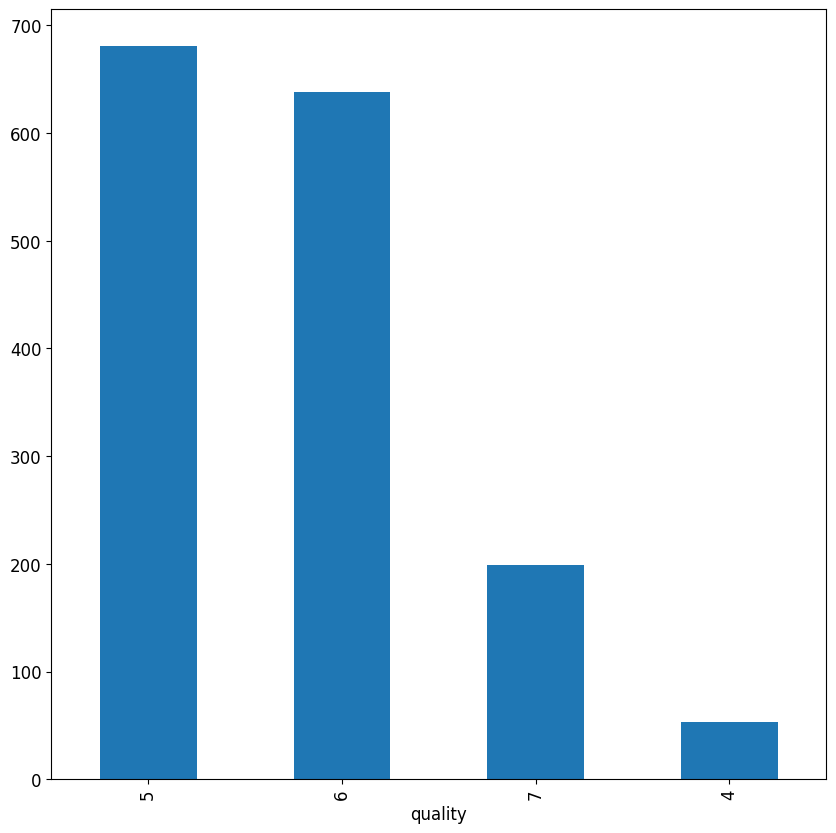

In [131]:
#We have a lot of ways for plotting this graph
df["quality"].value_counts().plot(kind="bar")
plt.show()

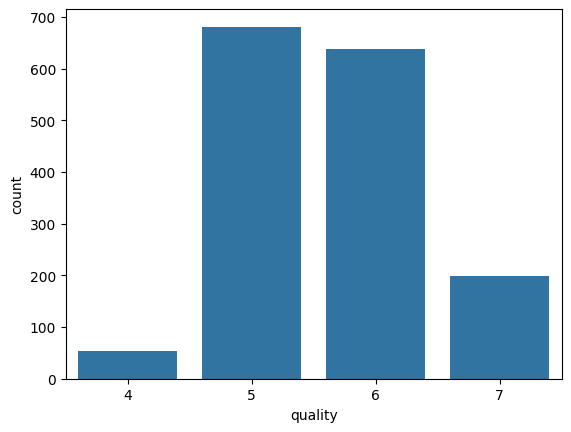

In [28]:
sns.barplot(x=df["quality"].value_counts().index,y=df["quality"].value_counts())
plt.show()

#### Split the data into the predicting values X and the class y
Drop also the columns which are not relevant for training a classifier, if any

The method "drop" of dataframes allows to drop either rows or columns
- the "axis" parameter chooses between dropping rows (axis=0) or columns (axis=1)

In [33]:
df.info()
X = df.drop("quality",axis=1)
y = df["quality"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571 entries, 0 to 1570
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1571 non-null   float64
 1   volatile acidity      1571 non-null   float64
 2   citric acid           1571 non-null   float64
 3   residual sugar        1571 non-null   float64
 4   chlorides             1571 non-null   float64
 5   free sulfur dioxide   1571 non-null   float64
 6   total sulfur dioxide  1571 non-null   float64
 7   density               1571 non-null   float64
 8   pH                    1571 non-null   float64
 9   sulphates             1571 non-null   float64
 10  alcohol               1571 non-null   float64
 11  quality               1571 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 147.4 KB


### Prepare the baseline: holdout method

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7002,random_state=42)
print(f"In our training data we 70% of the data, equal to {X_train.shape[0]} samples")
print(f"In our test data we 30% of the data, equal to {X_test.shape[0]} samples")

In our training data we 70% of the data, equal to 1100 samples
In our test data we 30% of the data, equal to 471 samples


- Initialize an estimator with the required model generator `tree.DecisionTreeClassifier(criterion="entropy")`
- Fit the estimator on the train data and target

In [43]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion="entropy")
model.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy')

In [45]:
from sklearn.metrics import accuracy_score
y_data_dt = model.predict(X_train)
print(f"accuracy score for training data is --> {accuracy_score(y_data_dt,y_train)*100}%")


accuracy score for training data is --> 100.0%


Let's see how it works on test data, and, comparing with the result on training data, see if you can suspect *overfitting*
- use the fitted estimator to predict using the test features
- compute the accuracy and store it on a variable for the final summary
- store the maximum depth of the tree, for later use 
    - `fitted_max_depth = estimator.tree_.max_depth`
- store the range of the parameter which will be used for tuning
    - `parameter_values = range(1,fitted_max_depth+1)`
- print the accuracy on the test set and the maximum depth of the tree

In [51]:
y_test_dt = model.predict(X_test)
print(f"accuracy score for training data is --> {accuracy_score(y_test_dt,y_test)*100}%")

fitted_max_depth = model.tree_.max_depth
parameter_values = range(1,fitted_max_depth+1)
print(f"The maximum depth of the tree is {fitted_max_depth} we can see that there is an obvious OF of the model due to the nature of unpruned DT")


accuracy score for training data is --> 59.23566878980891%
The maximum depth of the tree is 17 we can see that there is an obvious OF of the model due to the nature of unpruned DT


Prepare the decision tree parameters and the scores 

In [52]:
# Set the parameters by cross-validation
tuned_param_dt = [{'max_depth': [*parameter_values]
                , 'criterion' : ['entropy', 'gini']}]

scores = ['accuracy'
        # , 'precision_macro'
        , 'recall_macro'
        , 'f1_macro']

### Loop on scores
- iterate varying the score function
    - fit the estimator using the training data and Cross Validation with `GridSearchCV(estimator, parameters, cv_folds)`
        - the resulting model will be the best one according to the current score function
    - print the best estimator
    - print the best parameter set and the results for each set of parameters using the above defined function
    - predict the target for the test set using the `.predict` method
    - print the classification report
    - display the confusion matrix with `ConfusionMatrixDisplay`

In [122]:
from sklearn.metrics import confusion_matrix
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size'   : 12})

FOR SCORING FUNCTION -----> accuracy
DecisionTreeClassifier(max_depth=17)
{'criterion': 'gini', 'max_depth': 17}
accuracy score for training data is --> 62.42038216560509%
              precision    recall  f1-score   support

           4       0.05      0.07      0.06        15
           5       0.70      0.65      0.67       201
           6       0.62      0.66      0.64       190
           7       0.58      0.57      0.57        65

    accuracy                           0.62       471
   macro avg       0.49      0.49      0.49       471
weighted avg       0.63      0.62      0.63       471



<Figure size 15000x15000 with 0 Axes>

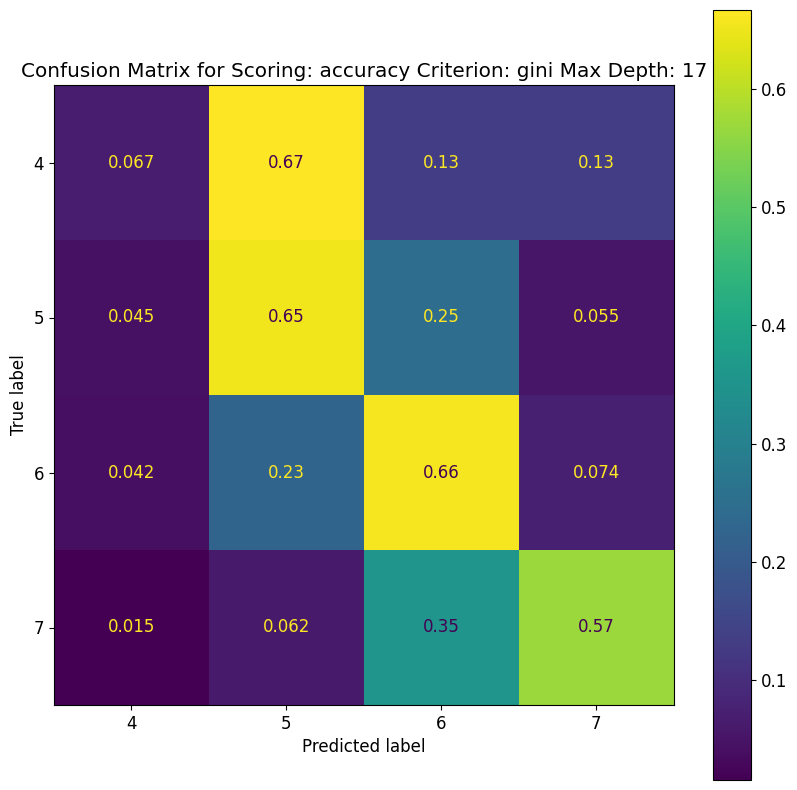

FOR SCORING FUNCTION -----> recall_macro
DecisionTreeClassifier(max_depth=11)
{'criterion': 'gini', 'max_depth': 11}
accuracy score for training data is --> 59.023354564755834%
              precision    recall  f1-score   support

           4       0.08      0.07      0.07        15
           5       0.65      0.65      0.65       201
           6       0.56      0.62      0.59       190
           7       0.59      0.45      0.51        65

    accuracy                           0.59       471
   macro avg       0.47      0.45      0.45       471
weighted avg       0.59      0.59      0.59       471



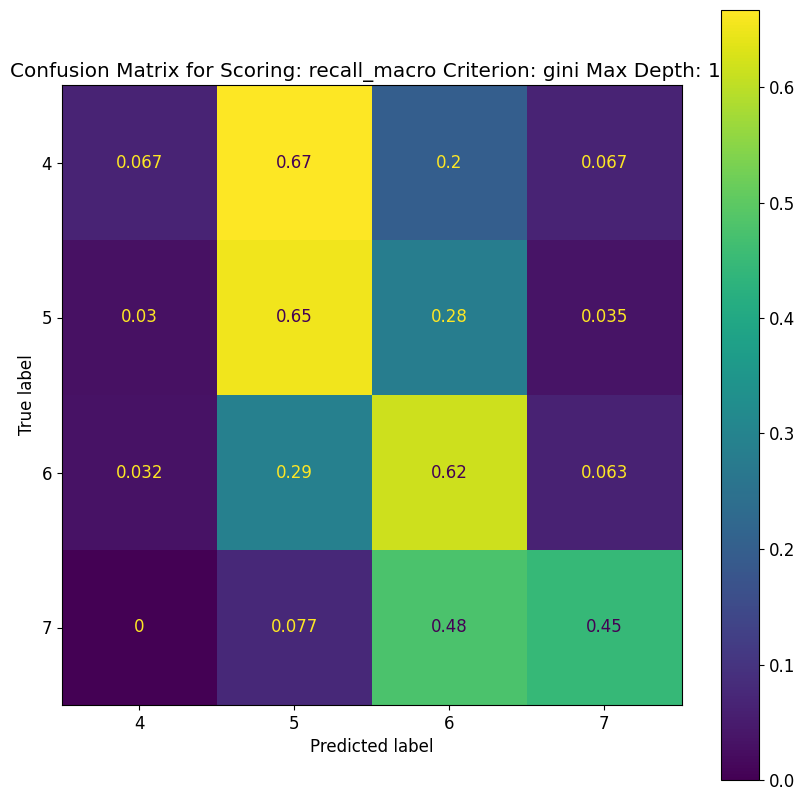

FOR SCORING FUNCTION -----> f1_macro
DecisionTreeClassifier(max_depth=11)
{'criterion': 'gini', 'max_depth': 11}
accuracy score for training data is --> 59.23566878980891%
              precision    recall  f1-score   support

           4       0.07      0.07      0.07        15
           5       0.66      0.66      0.66       201
           6       0.58      0.59      0.59       190
           7       0.55      0.51      0.53        65

    accuracy                           0.59       471
   macro avg       0.46      0.46      0.46       471
weighted avg       0.59      0.59      0.59       471



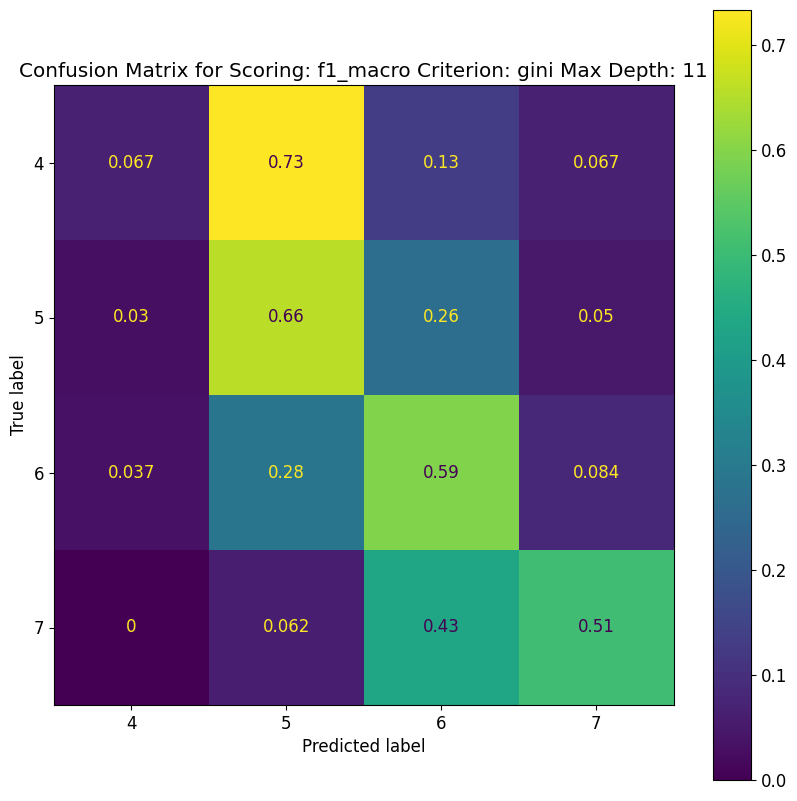

In [126]:
plt.figure(figsize=(150,150))
for score in scores:
    clf = GridSearchCV(estimator = model,param_grid=tuned_param_dt,scoring=score,cv=5)
    clf.fit(X_train,y_train)
    print(f"FOR SCORING FUNCTION -----> {score}")
    print(clf.best_estimator_)
    bp = clf.best_params_
    print(clf.best_params_)
    y_dt = clf.best_estimator_.predict(X_test)
    print(f"accuracy score for training data is --> {accuracy_score(y_dt,y_test)*100}%")
    print(classification_report(y_test,y_dt,target_names=["4","5","6","7"]))
    cm = confusion_matrix(y_test,y_dt,labels=clf.best_estimator_.classes_,normalize="true")
    disp = ConfusionMatrixDisplay(cm,display_labels=clf.classes_)
    disp.plot()
    disp.ax_.set_title(f"Confusion Matrix for Scoring: {score} Criterion: {bp["criterion"]} Max Depth: {bp["max_depth"]}")
    plt.show()
    
